#  Evolutionary Multiple-objective Optimization (part for 4.0)

- This script is for those who want to improve their final grade from 3.0 to 4.0. 
- Your task is to implement any one evolutionary algorithm for multiple-objective optimization introduced during the lecture (NSGA/NSGA-II/NSGA-II/MOEA/D/IBEA/HypE/SPEA2). It is recommended to implement NSGA-II or MOEA/D. 
- Note that it has to be your implementation (using external libraries is forbidden).
- The problem to be solved is the portfolio optimization tackled during lab 1.
- You can use the same data and price predictions as you made for lab 1 (Bundle1.zip) or update them accordingly to the next stage if you participate in the portfolio game (it is up to you).
- Apart from the two-objective scenario, consider also the three-objective one. As for the third objective, think about some reasonable risk-measure. You can maximize the number of non-zero weights, which should refer to minimizing risk by diversifying investments.
- Perform experimental evaluation of your implementation. You can use, e.g., the IDG or the HV metric to quantify the quality of populations constructed by the method.
- The experimental evaluation should be "reasonably extensive." E.g., run your method multiple times and average the results, show average convergence plots, do the sensitivity analysis (just four combinations of population size/generations will be enough), and depict some final populations. Also, compare the populations (only for 2D scenarios) with those generated by the ECM or WSM algorithm. Note that ECM and WSM already generate Pareto optimal solutions, so these can be considered good benchmarks for comparison.
- You can report your results here, i.e., in the jupyter notebook. You do not need to prepare any pdf report, etc. 

In [78]:
from utils import *

dataPath = "./data/Bundle2"

stock_data = readData(dataPath)


In [97]:
risk_matrix=(risk_matrix-np.min(risk_matrix))/(np.max(risk_matrix)-np.min(risk_matrix)) 

/home/adamczykb/projects/moo/.venv/lib/python3.11/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


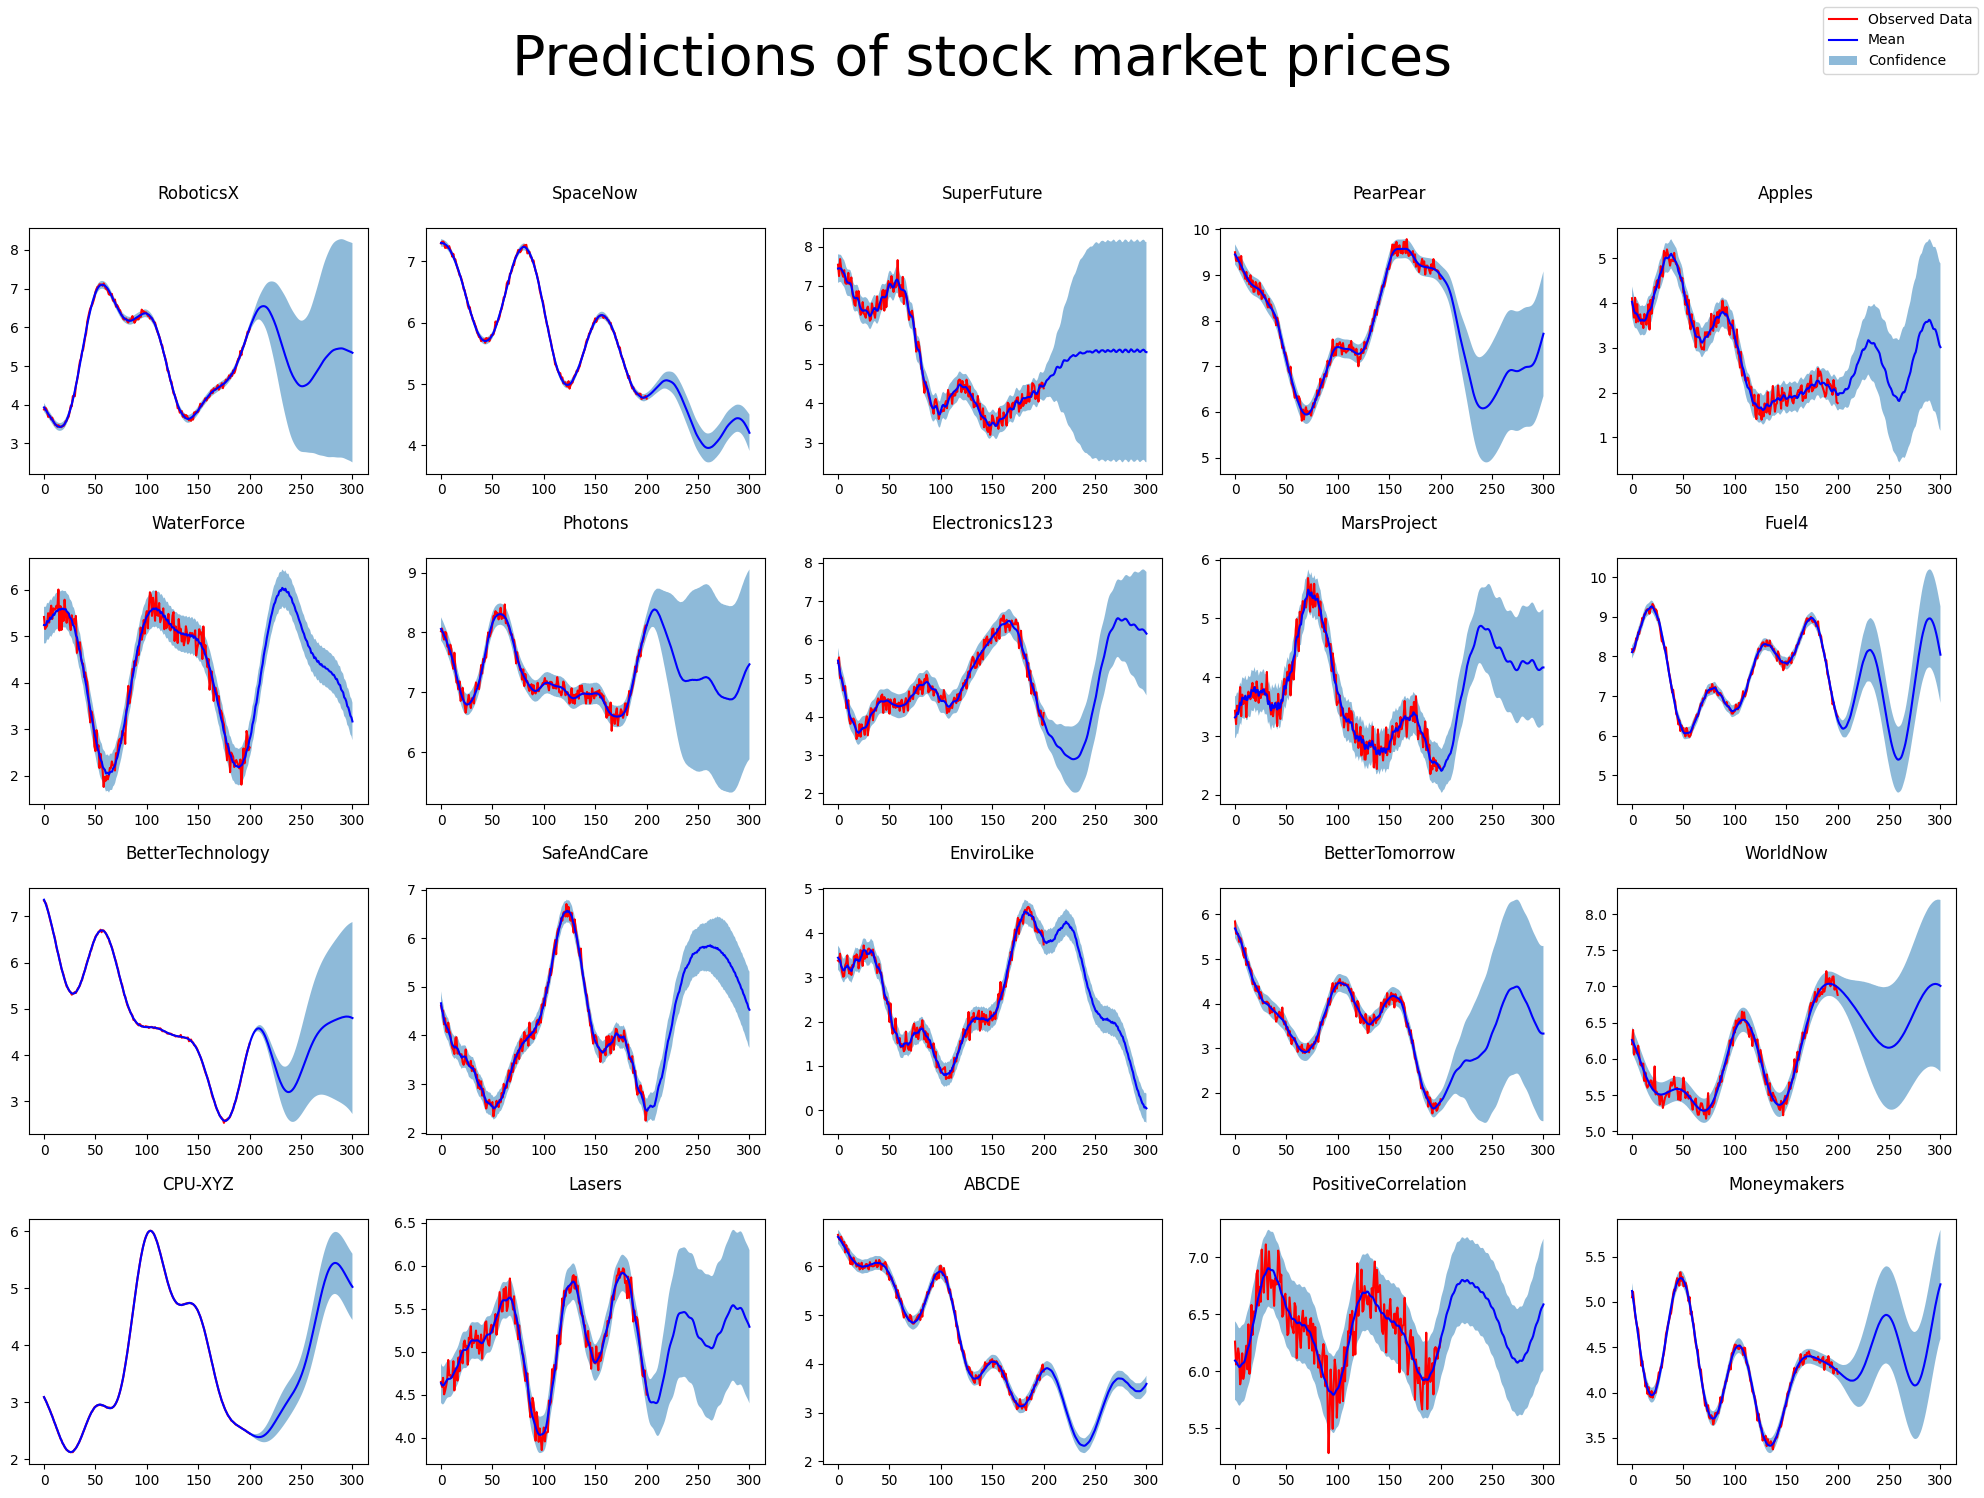

In [79]:
import matplotlib.pyplot as plt

stock_data, confidences = getPredictions(stock_data,300)
max_return = max([i.increase for i in stock_data])
min_return = min([i.increase for i in stock_data])
for i in range(len(stock_data)): #to minimise
    stock_data[i].increase=((max_return-min_return)-(stock_data[i].increase-min_return))/(max_return-min_return)
risk_matrix = getRiskMatrix(stock_data)
risk_matrix+=np.min(risk_matrix)
fig, axes = plt.subplots(4, 5, figsize=(20, 15))
fig.tight_layout(h_pad=5)
plt.subplots_adjust(top=0.85)
for company_idx, company in enumerate(stock_data):
    x = torch.Tensor(company.datax)
    y = torch.Tensor(company.datay)

    row = company_idx // 5
    col = company_idx - row * 5

    axes[row, col].set_title(company.name)
    axes[row, col].plot(x.numpy(), y.numpy(), 'r-')

    axes[row, col].plot(company.pred_datax, company.pred_datay, 'b')
    axes[row, col].fill_between(company.pred_datax, confidences[company.name][0], confidences[company.name][1], alpha=0.5)
fig.suptitle("Predictions of stock market prices", fontsize = 40)
fig.legend(['Observed Data', 'Mean', 'Confidence'], loc='upper right')
plt.savefig('pred2.svg')
plt.show()

In [148]:
import numpy as np
import math

class MOEA_D():
    def __init__(self, stock_data, population_size, num_iterations, num_objectives, num_neighbors, crossover_rate, mutation_rate):
        self.stock_data = stock_data
        self.solution_size = len(stock_data)
        self.population_size = population_size
        self.num_iterations = num_iterations
        self.num_objectives = num_objectives
        self.num_neighbors = num_neighbors
        self.old_points=[]
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.mutation_prob=3
        self.criteria_weights=[1,1]
        self.indexes_to_delete=[]
        self.population = self.initialize_population()
        self.population_points = self.calc_population_points() 
        
        self.a_objective_lines={}

        self.create_objectives_lines()
        self.check_distance_to_objective_lines_and_assign_one()

    def initialize_population(self):
        temp={}
        for i in range(self.population_size):
            temp[i]=self.generate_random_solution()
        return temp

    def w_chebyshev(self,population_point):
        return max([population_point[c]*self.criteria_weights[c] for c in self.criteria_weights])

    def check_distance_to_objective_lines_and_assign_one(self):
        for objective_l in list(self.a_objective_lines.keys()):
            best_point=list(self.population.keys())[0]
            best_distance= self.distance_point_line(best_point,self.population_points[best_point][0],self.population_points[best_point][1])
            for point in list(self.population_points.keys())[1:]:
                point_coord = self.population_points[point]
                temp_d = self.distance_point_line(objective_l,point_coord[0],point_coord[1])
                if best_distance>temp_d:
                    best_point=point
                    best_distance=temp_d
            self.a_objective_lines[objective_l].append([best_point,self.w_chebyshev(self.population_points[best_point])])
        
        for a in self.a_objective_lines.keys():
            temp=self.a_objective_lines[a]
            if len(temp)>1:
                temp=sorted(temp, key=lambda x:x[1])
                self.a_objective_lines[a]=[temp[0]]

        self.clean_dominated()
        
    def clean_dominated(self):
        current = [i[0][0] for i in self.a_objective_lines.values()]
        for k in list(set(self.population_points.keys())-set(current)):
            self.old_points.append(self.population_points[k])
            del self.population_points[k]
            del self.population[k]
    def points_distance(self, p1,p2):
        return ((p1[0] - p2[0])**2+(p1[1] - p2[1])**2)**0.5

    def find_k_closest_neighbours(self, i, k=2):
        stack=[[key,self.points_distance(self.population_points[key],self.population_points[i])] for key in self.population_points.keys()]
        return list(np.array(sorted(stack,key=lambda x:x[1]))[:k,0])


    def distance_point_line(self,a,x,y):
        return abs(a*x-y)/(a*a+1)**0.5

    def create_objectives_lines(self):
        for deg in np.linspace(0,89,self.num_objectives): # if 3D add new key for each existing
            self.a_objective_lines[math.tan(np.deg2rad(deg))]=[] #point, distance, value
    

    def generate_random_solution(self):
        solution = np.random.uniform(size=self.solution_size)
        solution /= solution.sum()
        return solution
    


    def calc_point(self, solution_weights) : # returns x,y
        return (
            sum([float(stock_data[j].increase) * solution_weights[j] for j in range(len(stock_data))]),
            sum([sum(risk_matrix[j]) * solution_weights[j] for j in range(len(stock_data))])/10
        )
        

    def calc_population_points(self):
        temp={}
        for i in self.population.keys():
            temp[i]=self.calc_point(self.population[i])
        return temp
        
    def select_neighbours(self,i):
        return self.find_k_closest_neighbours(i,k=num_neighbors)
        

    def crossover(self,population_idx):
        corssover_product = np.random.randint(0,len(population_idx),len(self.stock_data))
        return [self.population[population_idx[i]][pos] for pos,i in enumerate(corssover_product)]
    
    def mutate(self,offspring):
        offspring+=np.random.binomial(1, self.mutation_prob/len(offspring), len(offspring))* np.random.random(len(offspring))
        offspring /= offspring.sum()
        return offspring
        
    def update_population(self):
        self.check_distance_to_objective_lines_and_assign_one()

    
    def solve(self):
        for iteration in range(self.num_iterations):
            iter_keys=list(self.population.keys())
            for i in iter_keys:
                neighbours = self.select_neighbours(i)
                offspring = self.crossover(neighbours)
                # if any([self.w_chebyshev(offspring) < self.w_chebyshev(self.population[i])]):
                #     neighbours.append(max(self.population.keys())+1)
                #     self.population[neighbours[-1]]=offspring
                #     self.population_points[neighbours[-1]]=self.calc_point(offspring)
                    
                offspring = self.mutate(offspring)
                # if any([self.w_chebyshev(offspring) < self.w_chebyshev(self.population[i])]):
                neighbours.append(int(max(list(self.population.keys()))+1))
                self.population[neighbours[-1]]=offspring
                self.population_points[neighbours[-1]]=self.calc_point(offspring)
            self.update_population()
        
        return self.population,self.population_points.values(),self.old_points,list(self.a_objective_lines.keys())

In [ ]:
for deg in np.linspace(0,89,10): # if 3D add new key for each existing
    print(math.tan(np.deg2rad(deg)))
print(math.tan(1.56))

0.0
0.1743281132124263
0.35958409162862753
0.569619131092747
0.8259662077496615
1.168553293760272
1.6864261243174552
2.6355974414122887
5.198355252690343
57.289961630759144
92.62049631670456


(0.0, 1.0, 0.0, 1.0)

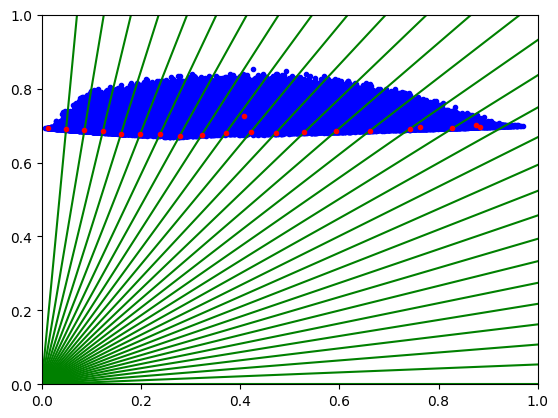

In [152]:
population_size = 300
num_iterations = 10000
num_objectives = 30
num_neighbors = 5
crossover_rate = 0.9
mutation_rate = 0.1

solver = MOEA_D(stock_data, population_size, num_iterations, num_objectives, num_neighbors, crossover_rate, mutation_rate)

sol = solver.solve()
# print(sol)
points = np.array(list(sol[1]))
old_points = np.array(list(sol[2]))
straight = np.array(list(sol[3]))
plt.plot(old_points[:,0],old_points[:,1],'b.')
for i in straight[:-1]:
    plt.axline((0,0),(1,i), color='g')
plt.plot(points[:,0],points[:,1],'r.')
plt.axis([0,1,0,1])


In [136]:
min_return = min([i.increase for i in stock_data])
min(old_points[:,1])

6.856692883758309